# Louis George    

## Modeling

In [88]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from xgboost import XGBClassifier

import joblib

import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='lougeo', api_key=os.environ.get("PLOTLY_API"))

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rc('ytick', labelsize=15)

### Reading in the data

In [2]:
X_train_tfidf = pd.read_csv('../../data/X_train_tfidf.csv')
X_test_tfidf = pd.read_csv('../../data/X_test_tfidf.csv')

In [3]:
X_train_countv = pd.read_csv('../../data/X_train_countv.csv')
X_test_countv = pd.read_csv('../../data/X_test_countv.csv')

In [4]:
y_imdb_train = pd.read_csv('../../data/y_imdb_train.csv')
y_rt_train = pd.read_csv('../../data/y_rt_train.csv')
y_profit_train = pd.read_csv('../../data/y_profit_train.csv')

y_imdb_test = pd.read_csv('../../data/y_imdb_test.csv')
y_rt_test = pd.read_csv('../../data/y_rt_test.csv')
y_profit_test = pd.read_csv('../../data/y_profit_test.csv')

### Exploring the possibility of using Latent Dirichlet Allocation for decomposition      

Due to the differences in scale between the genre dummies, part of speech counts, and word vectors, I will use only the word vectors. Scaling is not required when modeling using the full data set with Logistic Regression and Decision Tree based models, so this won't be an issue going forward.

In [5]:
X_train_countv_vecs = X_train_countv.iloc[:, 28:]
X_test_countv_vecs = X_test_countv.iloc[:, 28:]

In [37]:
topic_num = [3, 5, 10, 20]

train_scores = []
test_scores = []

for i in topic_num:
    lda = LatentDirichletAllocation(n_components=i).fit(X_train_countv_vecs)
    lda_train_weights = lda.transform(X_train_countv_vecs)
    lda_test_weights = lda.transform(X_test_countv_vecs)
    
    logreg = LogisticRegression().fit(lda_train_weights, y_imdb_train)
    train_scores.append(logreg.score(lda_train_weights, y_imdb_train))
    test_scores.append(logreg.score(lda_test_weights, y_imdb_test))

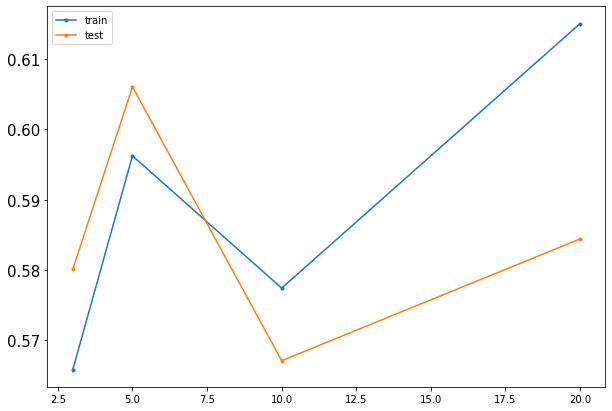

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(topic_num, train_scores, marker='.', label='train')
plt.plot(topic_num, test_scores, marker='.', label='test')
plt.legend()

As we can see from this graph, LDA decomposition is not going to give us any good results. For fun, let's see what the topics look like for one of the more reasonable results:

In [7]:
# Function which shows the features with the highest coefficients for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# This function is courtesy of the sklearn documentation @:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [8]:
topic_num = 20

lda = LatentDirichletAllocation(n_components=topic_num).fit(X_train_countv_vecs)

#transforming for t-SNE
lda_transformed = lda.transform(X_train_countv_vecs)

n_top_words = 20
feature_names = X_train_countv_vecs.columns

print_top_words(lda, feature_names, n_top_words)

Topic #0: cont'd bob continue continue draft v.o daddy lady child final lord button family ` kitchen buddy dragon stage dr road elizabeth
Topic #1: to gun go to ace edward be doc -PRON- ya shit fuckin road v.o fuck horse hawk truck town money get to
Topic #2: arthur father soldier child horse sir king sword precious german glance whale castle crowd ride draw prince guard book war
Topic #3: john nick walter adam smith west thomas alike dr hull evil wolf dance phone continue continue police guy mr detective camera
Topic #4: jim bobby mile whip master easy bloom green to grace charles yeah go to snake camera daniel fuck father worth money
Topic #5: mary peter roger dan draw steve priest de henry chase zombie candy la thomas creature rabbit family doom sister superior
Topic #6: yeah guy cont'd to okay phone go to fuck mark shit mom dad dave school fucking apartment uh o.s office bedroom
Topic #7: frank michael steve bud mark camera buddy bush honey jimmy mr mrs cut int phone apartment o.s 

This is a lot to look at, and even if there were fewer topics it would still be difficult for me to just look at these lists of words and make any sense out of it (These are just 20 words out of the whole data set!). To simplify this task let's make some plots! Below are a 2d, and 3d tSNE plots classed using KMeans clustering:

#### 2D t-SNE plot

In [11]:
my_tSNE = TSNE(n_components=2)
X_tSNE = my_tSNE.fit_transform(lda_transformed)

k_means_model = KMeans(n_clusters = 20)
k_means_model.fit(X_tSNE)
pred_labels = k_means_model.labels_

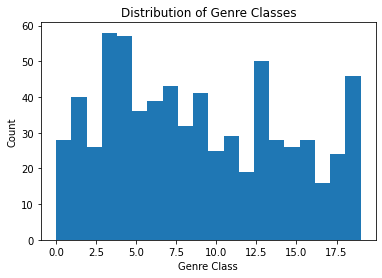

In [12]:
plt.figure()
plt.hist(pred_labels, bins=20)
plt.title("Distribution of Genre Classes")
plt.xlabel("Genre Class")
plt.ylabel("Count")
plt.show();

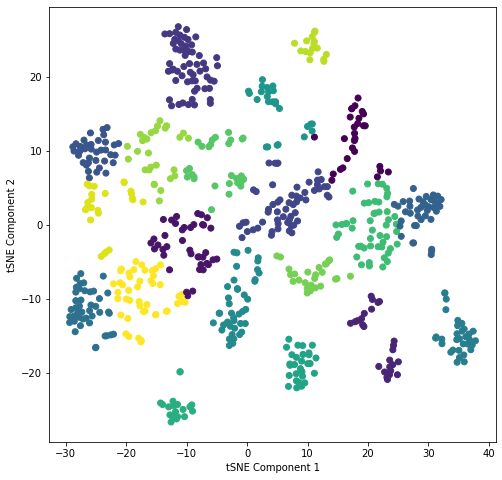

In [13]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1], c=pred_labels)

plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

plt.show()

Looks like there is some distinct clustering going on! Let's see what this looks like in 3D!

#### 3D t-SNE

In [35]:
scaled_X_train = StandardScaler().fit_transform(lda_transformed)

my_tSNE_3d = TSNE(n_components=3)
X_tSNE_3d = my_tSNE_3d.fit_transform(scaled_X_train)

k_means_model_3d = KMeans(n_clusters = 20)
k_means_model_3d.fit(X_tSNE_3d)
pred_labels_3d = k_means_model_3d.labels_

In [106]:
fig = go.Figure(data=[go.Scatter3d(
                                    x=X_tSNE_3d[:,0],
                                    y=X_tSNE_3d[:,1],
                                    z=X_tSNE_3d[:,2],
                                    mode='markers', 
                                    name='LDA Groups', 
                                    meta=pred_labels_3d, 
                                    marker=dict(
                                        size=10,
                                        color=pred_labels_3d, 
                                        colorscale='rainbow',
                                        opacity=1),
                                    hovertemplate='%{meta}', 
                                    )])

camera = dict(eye=dict(x=1, y=2, z=0.2))

fig.update_layout(scene_camera=camera)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30), 
                  height=600, 
                  width=600, 
                  title_text="t-SNE Visualization of LDA Groupings")
fig.show()

# Loading onto cloud
#py.iplot(fig, filename="tSNE")

PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, 'https://plotly.com/~lougeo/52/', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

It's pretty hard to make any sense of this many topics. Ideally it would have resulted in topics which could be distinguished as genres, but it isn't super obvious.    

Moving forward, we'll focus on tf-idf.

### TFIDF

In [147]:
targets = [['IMDb', y_imdb_train, y_imdb_test], 
           ['Rotten Tomatoes', y_rt_train, y_rt_test], 
           ['Profit Margin', y_profit_train, y_profit_test]]

In [148]:
def log_modeler(targets):
    
    scores = []
    
    for source, y_train, y_test in targets:
        # Pipeline
        estimators = [('model', LogisticRegression())]

        pipe = Pipeline(estimators)

        # Grid search
        param_grid = [{'model':[LogisticRegression()],
                       'model__penalty':['l1', 'l2'],
                       'model__C':np.logspace(-2, 2, 5, 10)}]

        grid = GridSearchCV(pipe, param_grid, cv=5)
        logreg_best = grid.fit(X_train_tfidf, y_train)

        # Taking params from best model because we will need the coefficients
        C_val = logreg_best.best_params_['model__C']
        penalty_val = logreg_best.best_params_['model__penalty']

        # Refitting the model so that we have the normal methods available
        logreg = LogisticRegression(C=C_val, penalty=penalty_val).fit(X_train_tfidf, y_train)
        
        # Pickling the model
        joblib.dump(logreg, f'../models/{source.split()[0]}_logreg.pkl')
        
        # Saving the scores
        scores.append([logreg.score(X_train_tfidf, y_train), logreg.score(X_test_tfidf, y_test)])

        # Creating a dataframe to compare the coefficient values
        lr_coefs = pd.DataFrame({'Coef':X_train_tfidf.columns,
                                 'Value':logreg.coef_[0]})
        lr_t10 = lr_coefs.sort_values(by='Value', ascending=False).head(10)

        # Plotting the results
        plt.figure(figsize=(12,7))
        plt.barh(lr_t10['Coef'], abs(lr_t10['Value']))
        plt.title(f"Features with the Highest Coefficient \n {source} Logistic Regression")
        plt.xlabel("Coefficient Value")
        plt.savefig(f"../plots/{source.split()[0]}_logreg.png");
    
    return scores

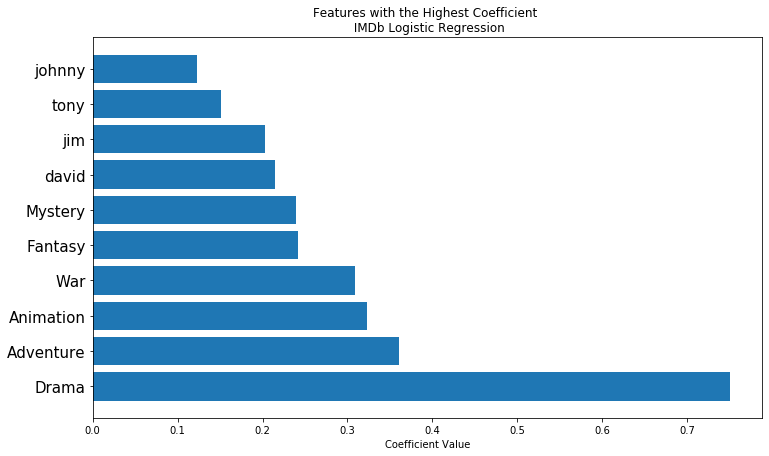

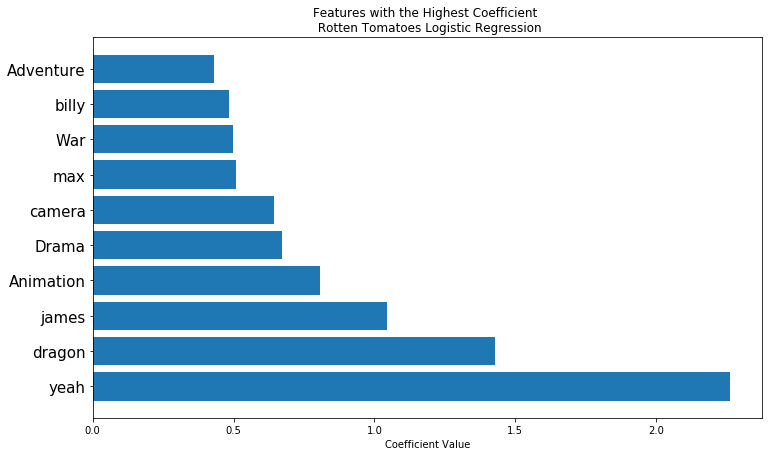

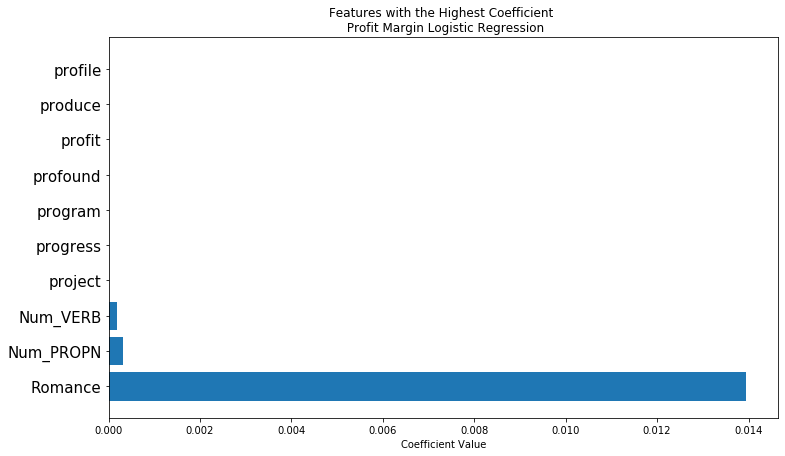

In [149]:
logreg_scores = log_modeler(targets)

In [150]:
logreg_scores

[[0.6714905933429812, 0.6320346320346321],
 [0.6874095513748191, 0.5584415584415584],
 [0.5947901591895803, 0.6277056277056277]]

In [160]:
logreg_profit = joblib.load('../models/Rotten_logreg.pkl')

In [161]:
logreg_profit.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)>

Weird results with the l1 penalty. Results in a higher test score than training for Profit. Also it's a v shit result maybe less than random.

In [164]:
def xgbc_modeler(targets):
    
    scores = []
    
    for source, y_train, y_test in targets:
        
        # Pipeline
        estimators = [('model', XGBClassifier())]
        pipe = Pipeline(estimators)
        
        # Grid search
        param_grid = [{'model':[XGBClassifier()],
                       'model__max_depth':[4, 5, 6, 7],
                       'model__learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3],
                       'model__n_estimators':[50, 80, 100, 200]}]

        grid = GridSearchCV(pipe, param_grid, cv=5)
        xgbc_best = grid.fit(X_train_tfidf, y_train)

        # Taking params from best model because we will need the coefficients
        md_val = xgbc_best.best_params_['model__max_depth']
        lr_val = xgbc_best.best_params_['model__learning_rate']
        ne_val = xgbc_best.best_params_['model__n_estimators']
        
        # Refitting the model so that we have the normal methods available
        xgbc = XGBClassifier(max_depth=md_val, 
                             learning_rate=lr_val, 
                             n_estimator=ne_val).fit(X_train_tfidf, y_train)

        # Pickling the model
        joblib.dump(xgbc, f'../models/{source.split()[0]}_xgbc.pkl')
        
        # Saving the scores
        scores.append([xgbc.score(X_train_tfidf, y_train), xgbc.score(X_test_tfidf, y_test)])

        # Creating a dataframe to compare the coefficient values
        xg_coefs = pd.DataFrame({'Coef':X_train_tfidf.columns,
                                 'Value':xgbc.feature_importances_})
        xg_t10 = xg_coefs.sort_values(by='Value', ascending=False).head(10)

        # Plotting
        plt.figure(figsize=(12,7))
        plt.barh(xg_t10['Coef'], abs(xg_t10['Value']))
        plt.title(f"Features with the Highest Gain \n {source} XG Boost")
        plt.xlabel("Gain")
        plt.savefig(f"../plots/{source.split()[0]}_xgbc.png");
    
    return scores

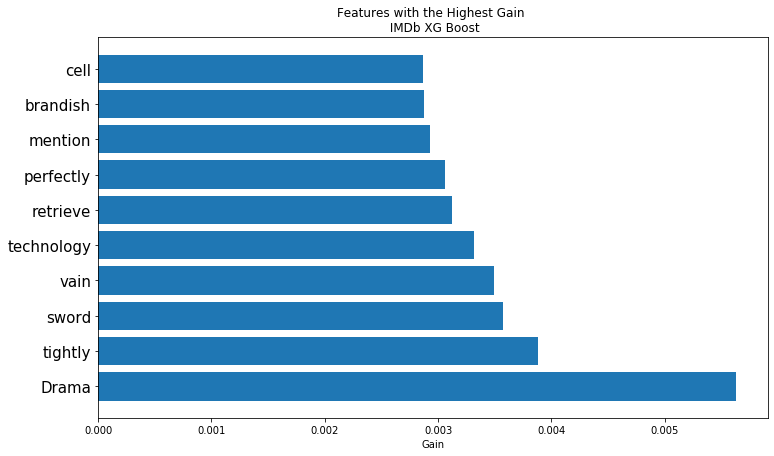

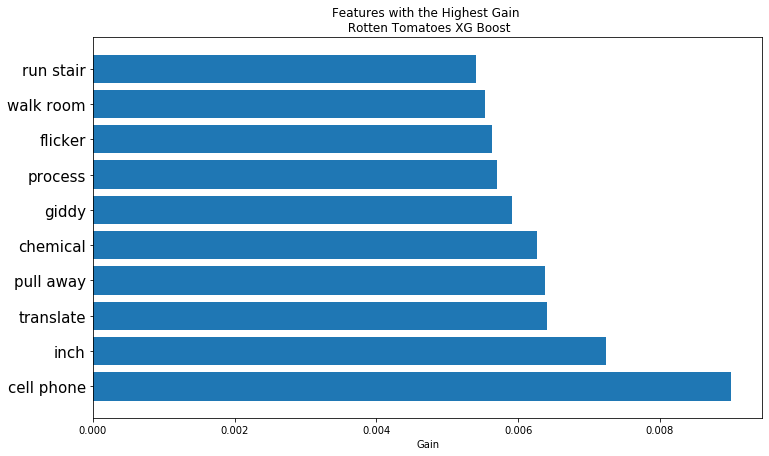

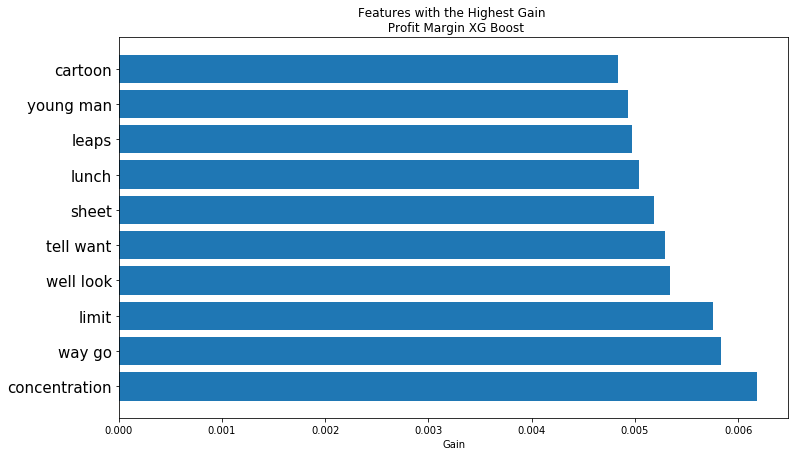

In [165]:
xgbc_scores = xgbc_modeler(targets)

In [166]:
xgbc_scores

[[0.9985528219971056, 0.5930735930735931],
 [1.0, 0.6060606060606061],
 [1.0, 0.5930735930735931]]